In [1]:
from google.colab import drive
drive.mount('mobilenet')

Mounted at mobilenet


In [2]:
# import package

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os

# display images
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
from torchsummary import summary
import time
import copy

In [3]:
# specify path to data
transform = transforms.Compose(
    [transforms.ToTensor()])

train_ds = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)

val_ds = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=32, shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# Depthwise, Pointwise convolution
class depth_point(nn.Module):
    def __init__(self, input_size, output_size, stride=1):
        super().__init__()

        self.depthwise = nn.Sequential(
            nn.Conv2d(input_size, input_size, 3, stride=stride, padding=1, groups=input_size),
            nn.BatchNorm2d(input_size),
            nn.ReLU6(),
        )

        self.pointwise = nn.Sequential(
            nn.Conv2d(input_size, output_size, 1, stride=1, padding=0),
            nn.BatchNorm2d(output_size),
            nn.ReLU6()
        )
    
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

In [5]:
#MobileNet에 적용할 ResNext Block의 한 unit 
class BottleNeck(nn.Module):
    def __init__(self, in_planes,inner_planes, group = 32):
        super(BottleNeck, self).__init__()       
        ## mobilenet에서 resnext를 적용한 layer 구간: 
        ## (depthwise + pointwise conv w/ ch = 512)이 5개 연속인 구간
        ## group을 32개로 나눠 각 unit은 첫 layer를 제외하고 16개의 ch를 갖는다.
        ## 첫 layer에는 input ch이 512로 들어와 모든 unit의 input ch이 512dim이다. 
        self.dw = nn.Sequential(
          depth_point(in_planes, inner_planes, stride=1),
          depth_point(inner_planes, inner_planes, stride=1),
          depth_point(inner_planes, inner_planes, stride=1),
          depth_point(inner_planes, inner_planes, stride=1),
          depth_point(inner_planes, inner_planes, stride=1),
        )

    def forward(self, x):
        out = self.dw(x)
        return out

#MobileNet에 적용할 ResNext Block (32 groups)
class MobileNetBottleNeck(nn.Module):
  def __init__(self, in_planes=512, inner_planes=16, out_plane = 256, group = 32):
    super(MobileNetBottleNeck,self).__init__()
    self.group = group
    self.bottleneck_list = [BottleNeck(in_planes,inner_planes, group).to("cuda") for _ in range(self.group)]
  
  def forward(self, x):
    out = [self.bottleneck_list[i](x) for i in range(self.group)]   ## 32개의 서로 다른 unit 생성
    out = torch.cat(out, dim=1)                                     ## concatenate block units
    out += x                                                        ## skipped connection
    return out

# MobileNetV1
class MobileNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.init = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.conv1 = depth_point(32, 64)
        # down sample
        self.conv2 = nn.Sequential(
            depth_point(64, 128 , stride=2),
            depth_point(128, 128)
        )
        # down sample
        self.conv3 = nn.Sequential(
            depth_point(128, 256, stride=2),
            depth_point(256, 256)
        )
        self.conv4 = depth_point(256, 512, stride=2)

        self.conv5 = MobileNetBottleNeck(512, 16, 512, 32)
        # down sample
        self.conv6 = nn.Sequential(
            depth_point(512, 1024, stride=2)
        )
        # down sample
        self.conv7 = nn.Sequential(
            depth_point(1024, 1024, stride=2)
        )

        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.init(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

def mobilenet():
    return MobileNet()

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
x = torch.randn((32, 3, 32, 32)).to(device)
model = mobilenet().to(device)
output = model(x)
print('output size:', output.size())

cuda
output size: torch.Size([32, 10])


In [7]:
summary(model, (3, 32, 32), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             896
       BatchNorm2d-2           [-1, 32, 16, 16]              64
              ReLU-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]             320
       BatchNorm2d-5           [-1, 32, 16, 16]              64
             ReLU6-6           [-1, 32, 16, 16]               0
            Conv2d-7           [-1, 64, 16, 16]           2,112
       BatchNorm2d-8           [-1, 64, 16, 16]             128
             ReLU6-9           [-1, 64, 16, 16]               0
      depth_point-10           [-1, 64, 16, 16]               0
           Conv2d-11             [-1, 64, 8, 8]             640
      BatchNorm2d-12             [-1, 64, 8, 8]             128
            ReLU6-13             [-1, 64, 8, 8]               0
           Conv2d-14            [-1, 12

In [9]:
# define loss function, optimizer, lr_scheduler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = MobileNet().to(device)
loss_func = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=0.005)


# Function to train the network

def train_val(net, params_train): #, model_path='./cifar_net.pth'
    max_epoch=params_train['max_epoch']
    trainloader=params_train['train_dl']
    testloader=params_train['val_dl']
    crit=params_train['loss_func']
    opt=params_train['optimizer']
    path2weights = params_train['path2weights']
    history = []
    best_model_wts = copy.deepcopy(net.state_dict())
    start_time = time.time()
    best_loss = float('inf')
    
    for epoch in range(max_epoch):  # loop over the dataset multiple times

        print('Epoch {}/{}'.format(epoch+1, max_epoch))
        running_loss = 0.0
        net.train()
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels      
            inputs, labels = data

            # Training on GPU
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            opt.zero_grad()

            outputs = net(inputs)

            loss = crit(outputs, labels)
            loss.backward()
            opt.step()
 
            running_loss += loss.item()
        train_loss = running_loss / 50000

        net.eval()
        with torch.no_grad():
            running_loss_1 = 0.0
            running_metric_1 = 0.0
            for j, data_1 in enumerate(testloader, 0):
                    # get the inputs; data is a list of [inputs, labels]

                    inputs_1, labels_1 = data_1
                    inputs_1 = inputs_1.to(device)
                    labels_1 = labels_1.to(device)
     
                    # forward
                    outputs_1 = net(inputs_1)
                    loss1 = crit(outputs_1, labels_1)
                    

                    pred1 = outputs_1.argmax(1, keepdim=True)
                    metrics = pred1.eq(labels_1.view_as(pred1)).sum().item()
                    if metrics is not None:
                       running_metric_1 += metrics
                    # print statistics
                    running_loss_1 += loss1.item()                      
            metrix = running_metric_1 / 10000
            val_loss = running_loss_1 / 10000
            
            
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(net.state_dict())
            torch.save(net.state_dict(), path2weights)
            print('Copied best model weights!')

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*metrix, (time.time()-start_time)/60))
        history.append(metrix)
        print('-'*10)
        

    net.load_state_dict(best_model_wts)           
    #torch.save(net.state_dict(), model_path)
    print('Finished Training')
    print('Saved Trained Model')
    return history  

cuda


In [10]:
# define the training parameters
params_train = {
    'max_epoch':30,
    'optimizer':optimizer,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'path2weights':'./models/weights.pt',
}

# check the directory to save weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

In [11]:
history =  train_val(model, params_train)

Epoch 1/30
Copied best model weights!
train loss: 1.771312, val loss: 1.525950, accuracy: 44.45, time: 5.8292 min
----------
Epoch 2/30
Copied best model weights!
train loss: 1.434343, val loss: 1.309459, accuracy: 52.60, time: 11.5944 min
----------
Epoch 3/30
Copied best model weights!
train loss: 1.236398, val loss: 1.159661, accuracy: 58.78, time: 17.3348 min
----------
Epoch 4/30
Copied best model weights!
train loss: 1.066870, val loss: 0.993263, accuracy: 64.49, time: 23.0886 min
----------
Epoch 5/30
Copied best model weights!
train loss: 0.949093, val loss: 0.922536, accuracy: 67.73, time: 28.5866 min
----------
Epoch 6/30
Copied best model weights!
train loss: 0.867223, val loss: 0.866572, accuracy: 70.01, time: 34.2096 min
----------
Epoch 7/30
train loss: 0.798087, val loss: 0.914853, accuracy: 68.33, time: 39.6670 min
----------
Epoch 8/30
Copied best model weights!
train loss: 0.744051, val loss: 0.750347, accuracy: 74.00, time: 45.1407 min
----------
Epoch 9/30
train los

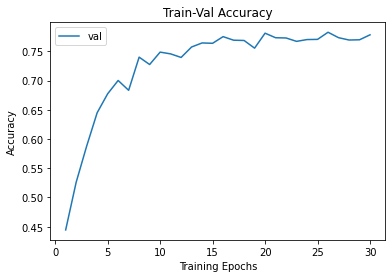

In [12]:
# train-val progress
num_epochs = params_train['max_epoch']
# plot accuracy progress
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), history, label='val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()